In [85]:
# Numerical analysis
import numpy as np
import jax.numpy as jnp
from jax import random
from jax.nn import sigmoid

# Bayesian inference
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
import arviz as az

# Dataframes
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Set pseudo random number key
prng_key = random.PRNGKey(2)

# MODEL CONSTANTS
n_realizations = 5

# MCMC PARAMETERS
num_warmup = 500
num_samples = 1000
num_chains = 2

# TESTING
lams = [1/2, 1/10, 1/500, 1/10000]
sigma = 1
p = 5/7

In [86]:
# Load data file
dset = pd.read_csv("data/azdiabetes.csv", sep=",")

def standardize(x):
    return (x-x.mean(0)) / x.std(0)

y = dset["diabetes one-hot"].values
X = dset[["npreg", "glu", "bp", "skin", "bmi", "ped", "age"]].values

X = standardize(X)


<h2> Defining the Model </h2>

$$\begin{align*} 
y &\sim \text{Bernoulli}(X\gamma) \\

\gamma_j &= \sigma \left(\frac{L_j + \log\alpha_j}{\lambda}\right) \text{  for   } j = 1, ..., D \\
L_j &= \log (U_j) - \log (1-U_j)\\
U_j &\sim \text{Uniform}(0, 1)
\end{align*}$$




Note that in order for the model to work correctly, $\alpha_i$ must be  $\in (0, \infty)$.


In addition, the shrinkage coefficient $\kappa_i = 1 - \gamma_i$ is recorded.

In [87]:
def model(alphas, lam, X, y=None):
    '''
    Defines the Concrete random variable distribution.

    Parameters:
       real lam: temperature coefficient
       array alphas: parameter, Dx1
       array X: input data, NxD
       array y: output data, Nx1
    '''
    D = X.shape[1]
    U = numpyro.sample("U", dist.Uniform(0, 1).expand([D])) 
    L = numpyro.deterministic("L", jnp.log(U) - jnp.log(1 - U)) 
    gammas = numpyro.deterministic("gammas", sigmoid((L + jnp.log(alphas)) / lam)) 
    kappas = numpyro.deterministic("kappas", 1 - gammas) 
    
    y_mean = jnp.dot(X, gammas) # NxD
    y = numpyro.sample("y", dist.Bernoulli(logits=y_mean), obs=y) 

In [88]:
def run_mcmc(model, prng_key, **kwargs):
    '''
    Run MCMC using the given model.

    Parameters:
       model: probabilistic model
       prng_key: random key 
       array y: observed data

    '''
    nuts = NUTS(model)
    mcmc = MCMC(nuts, num_warmup=num_warmup, num_samples=num_samples, num_chains=2, progress_bar=True)
    mcmc.run(prng_key, **kwargs)
    return mcmc

In [89]:
def concrete(X, y, lam):
    '''
    Parameters:
       dict all_data: keys are integers and values are the corresponding tuple (X, Y)
       int lam: temperature coefficient
    
    Returns:
       arr mses: size (D,)
       arr kappas: length len(A_values) * D
       arr mean_gammas: size (D,)
       arr betas: size (D,)
       dict samples: keys are sampled values in the mcmc model, values are the samples
       mcmc: a Numpyro MCMC object

    '''
    alphas = jnp.zeros(X.shape[1])
    alphas += p / (1-p)
    mcmc = run_mcmc(model, prng_key, alphas = alphas, lam = lam, X=X, y=y)
    samples = mcmc.get_samples()
    mean_gammas =  samples["gammas"]
    kappas = samples['kappas']
   #  plt.figure(figsize=(12, 6))
   #  print(mean_gammas.flatten())
   #  print(kappas)
   #  plt.subplot(1, 2, 1)
   #  sns.histplot(mean_gammas.flatten(), kde=True)
   #  plt.title('Distribution of Mean Gammas')

   #  plt.subplot(1, 2, 2)
   #  sns.histplot(kappas, kde=True)
   #  plt.title('Distribution of Kappas')

   #  plt.tight_layout()
   #  plt.show()
        
    return kappas, mean_gammas, samples, mcmc

<h1> Run and Evaluate MCMC </h1>

In [90]:
all_mses = dict()
mean_mses = dict()
all_kappas = dict()
mean_betas = dict()
mean_gammas = dict()
all_mcmc_runs = []
all_data = {}

for _ in range(n_realizations):
    for lam in lams:
        kappas, gammas, all_samples, mcmc = concrete(X, y, lam=lam)
        if lam not in all_kappas:
            all_kappas[lam] = []
        if lam not in mean_gammas:
            mean_gammas[lam] = []
        all_kappas[lam].append(kappas)
        mean_gammas[lam].append(gammas)
        all_mcmc_runs.append(mcmc)

/var/folders/5v/22m3m0gx4zn571r9xrn6pcb80000gn/T/ipykernel_39894/2872204839.py:12: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts, num_warmup=num_warmup, num_samples=num_samples, num_chains=2, progress_bar=True)
sample: 100%|██████████| 1500/1500 [00:00<00:00, 5298.28it/s, 15 steps of size 2.28e-01. acc. prob=0.94]
/var/folders/5v/22m3m0gx4zn571r9xrn6pcb80000gn/T/ipykernel_39894/2872204839.py:12: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are availab

The <a href=https://mc-stan.org/docs/2_21/reference-manual/effective-sample-size-section.html>estimated effective sample size (ESS)</a> measures how much information is lost in MCMC due to correlation between different samples.

The <a href=https://arxiv.org/abs/1812.09384>Gelman-Rubin statistic</a> ($\hat{R}$) examines how well the chains have mixed. Common thresholds used include $1.01$, $1.05$, and $1.1$.

In [91]:
for mcmc in all_mcmc_runs:
    mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      U[0]      0.24      0.07      0.25      0.15      0.35   1159.58      1.00
      U[1]      0.77      0.15      0.78      0.55      1.00   1301.73      1.00
      U[2]      0.06      0.04      0.05      0.00      0.12   1227.53      1.00
      U[3]      0.09      0.06      0.09      0.00      0.17    738.31      1.00
      U[4]      0.26      0.06      0.26      0.15      0.35    968.68      1.00
      U[5]      0.27      0.06      0.27      0.17      0.35   1441.43      1.00
      U[6]      0.14      0.07      0.15      0.02      0.25    826.55      1.00

Number of divergences: 0

                mean       std    median      5.0%     95.0%     n_eff     r_hat
      U[0]      0.28      0.03      0.28      0.26      0.31    232.70      1.01
      U[1]      0.67      0.19      0.66      0.39      0.96    443.70      1.00
      U[2]      0.12      0.07      0.12      0.00      0.22    485.43      1.00


<h1> Results </h1>

0.5 [0.3957818  0.9685854  0.03915528 0.08465318 0.42940494 0.46398705
 0.17586786]
0.1 [0.46751353 0.9969485  0.00845495 0.01735824 0.49096876 0.45540285
 0.08148908]
0.002 [6.0951084e-01 9.9997741e-01 3.8315036e-05 3.5850672e-04 6.1514002e-01
 5.3396970e-01 2.0077102e-02]
0.0001 [9.9841750e-01 9.9999952e-01 5.9566141e-16 4.0966352e-11 9.9794090e-01
 4.8800585e-01 5.7999456e-14]


(-0.05, 1.05)

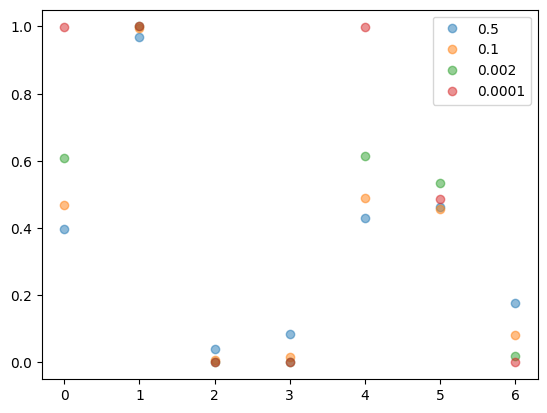

In [92]:
# for gamma in mean_gammas:
#     plt.plot(mean_gammas.keys(), mean_gammas.values(), '.', label=gamma, alpha=0.5)
# plt.legend()
# plt.title("Gamma values for different lambdas")
# plt.ylabel("Gamma")
# plt.xlabel("Entry #")

for lam in lams: 
    # for x in mean_gammas[lam]:
    #     plt.plot(x, '.', label=lam)
    #     # print(lam, mean_gammas[lam])
    plt.plot(np.array(mean_gammas[lam]).mean(0).mean(0), 'o', label=lam, alpha=0.5)
    print(lam, np.array(mean_gammas[lam]).mean(0).mean(0))

plt.legend()
plt.ylim(-0.05, 1.05)

(0.0, 1.0)

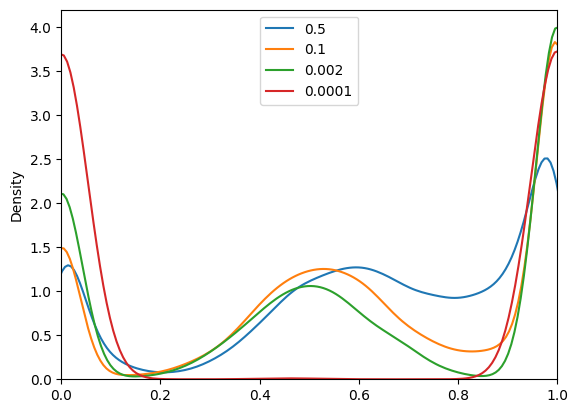

In [93]:
for lam in lams:
    all_kappas[lam] = np.ndarray.flatten(np.array(all_kappas[lam]))
    sns.kdeplot(all_kappas[lam], label=f'{lam}')
plt.legend()
plt.xlim(0, 1)

In [94]:
# samples_1 = mcmc.get_samples()
# predictive = Predictive(model, samples_1)
# predictions = predictive(random.PRNGKey(1),
#                          alphas = jnp.ones(X.shape[1]),
#                          lam=10000, 
#                          X=X,
#                          y=y)['y']
# mean_pred = predictions.mean(0)

# plt.plot(mean_pred, '.')
# plt.plot(y, '.')

# print(sum((mean_pred - y)**2))